In [0]:
import sys
sys.path.append('../')

In [0]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

from MaskedRNN import MaskedDeepRNN

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns

In [0]:
plt.rcParams.update({'font.size': 12})
sns.set_style('darkgrid')

In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') 

#### Import, shuffle and split dataset

In [0]:
data = pd.read_csv('reber_sequences.csv')

In [0]:
data = data.sample(frac=1).reset_index(drop=True)

In [0]:
train_data = data[:int(.75*len(data))]
test_data = data[len(train_data):]

In [8]:
print('Total length: {}\nTrain data length: {}\nTest data length: {}'.format(len(data), len(train_data), len(test_data)))

Total length: 25000
Train data length: 18750
Test data length: 6250


#### Parameters

In [0]:
MODEL = 'rnn-tanh'

In [0]:
BATCH_SIZE = 16

INPUT_SIZE = 128
EMBEDDING_DIM = 100
OUTPUT_SIZE = 2

EPOCHS = 30
HIDDEN_LAYERS = [50, 50, 50]

#### Customize `Dataset`

In [0]:
class MakeDataset(Dataset):
    def __init__(self, data):
        self.strings = list(data['string'])
        self.valid = list(data['valid'])
        self.len = len(self.valid)
        self.valid_list = [0, 1]

    def __getitem__(self, index):
        return self.strings[index], self.valid[index]

    def __len__(self):
        return self.len

#### Train/Test Loader

In [0]:
dataset = MakeDataset(train_data)
train_loader = DataLoader(dataset=dataset, batch_size=BATCH_SIZE, shuffle=True)

In [0]:
dataset = MakeDataset(test_data)
test_loader = DataLoader(dataset=dataset, batch_size=BATCH_SIZE, shuffle=True)

#### Helper functions

In [0]:
def create_variable(tensor):
    return Variable(tensor.to(device))

In [0]:
def pad_seq(vect_seqs, seq_lens, valid):
    seq_tensor = torch.zeros((len(vect_seqs), seq_lens.max())).long()
    
    for index, (seq, seq_len) in enumerate(zip(vect_seqs, seq_lens)):
        seq_tensor[index, :seq_len] = torch.LongTensor(seq)
        
    return create_variable(seq_tensor), create_variable(seq_lens), create_variable(valid)

In [0]:
def str2ascii(string):
    ascii_arr = [ord(s) for s in string]
    return ascii_arr, len(ascii_arr)

In [0]:
def make_variables(strings, valid):
    seqs_and_lens = [str2ascii(string)for string in strings]
    vect_seqs = [s[0] for s in seqs_and_lens]
    seq_lens = torch.LongTensor([s[1] for s in seqs_and_lens])
    valid = torch.LongTensor(valid)
    return pad_seq(vect_seqs, seq_lens, valid)

#### Model

In [0]:
class Model(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers: list, nonlinearity):
        super(Model, self).__init__()

        self.embedding = nn.Embedding(num_embeddings=input_size, embedding_dim=hidden_layers[0]).to(device)
        self.recurrent = MaskedDeepRNN(hidden_layers[0], hidden_layers, nonlinearity=nonlinearity).to(device)
        self.fc = nn.Linear(hidden_layers[-1], output_size).to(device)
        
    def forward(self, input):
        input = input.t()
        embedded = self.embedding(input)
        output = self.recurrent(embedded)
        return self.fc(output)

#### Train & Test

In [0]:
def train():
    total_loss = 0
    
    for i, (string, valid) in enumerate(train_loader, 1):
        input, seq_lens, target = make_variables(string, valid)

        output = model(input)
        
        loss = criterion(output, target)
        total_loss += loss.data.item()
        
        model.zero_grad()
        loss.backward()
        optimizer.step()

In [0]:
def test():
    correct = 0.
    test_data_size = len(test_loader.dataset)
    
    for string, valid in test_loader:
        input, seq_lens, target = make_variables(string, valid)

        output = model(input)

        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    acc = 100 * correct / test_data_size
    return acc

#### Pruning

In [0]:
pruned_perc = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
pruned_acc = []

In [0]:
model = Model(INPUT_SIZE, OUTPUT_SIZE, HIDDEN_LAYERS, nonlinearity='tanh')

In [23]:
param_dict = torch.load('rnn-tanh-dict.pt')
model.load_state_dict(param_dict)

<All keys matched successfully>

In [24]:
for perc in pruned_perc:
    print('Pruned {}%'.format(perc))
    model.recurrent.set_i2h_mask(perc)
    acc = test()
    print('Accuracy: {:.2f}%\n'.format(acc))
    pruned_acc.append(acc)

Pruned 10%
Accuracy: 94.08%

Pruned 20%
Accuracy: 94.08%

Pruned 30%
Accuracy: 94.08%

Pruned 40%
Accuracy: 94.08%

Pruned 50%
Accuracy: 94.08%

Pruned 60%
Accuracy: 94.08%

Pruned 70%
Accuracy: 92.93%

Pruned 80%
Accuracy: 70.46%

Pruned 90%
Accuracy: 49.84%

Pruned 100%
Accuracy: 50.16%



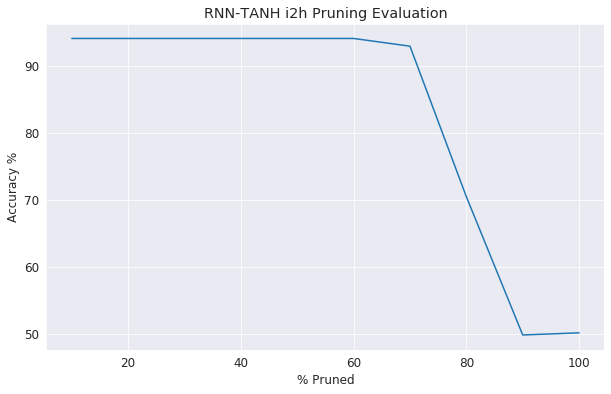

In [25]:
plt.figure(figsize=(10, 6))
plt.title('{} i2h Pruning Evaluation'.format(MODEL.upper()))
plt.xlabel('% Pruned')
plt.ylabel('Accuracy %')
plt.savefig('./accuracies/{}-i2h-pruning-accuracy.png'.format(MODEL))
plt.plot(pruned_perc, pruned_acc);

In [0]:
with open('./accuracies/{}-i2h-pruning-accuracies.txt'.format(MODEL), 'a') as f:
    f.write('{}'.format(MODEL.upper()) + ':' + ','.join(str(a.item()) for a in pruned_acc) + '\n')

#### Re-train

In [0]:
retrain_after = [80, 90, 100]
retrain_accs = []

In [28]:
%%time
for perc in retrain_after:
    model = Model(INPUT_SIZE, OUTPUT_SIZE, HIDDEN_LAYERS, nonlinearity='tanh')
    model.load_state_dict(param_dict)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    print('Pruned {}%\n{}'.format(perc, '-'*12))
    model.recurrent.set_i2h_mask(perc)

    base_acc = test()

    acc = [base_acc]
    for e in range(10):
        print('Epoch {}: {:.2f}%'.format(e, base_acc))
        train()
        base_acc = test()
        acc.append(base_acc)

    retrain_accs.append(acc)
    print('\n')

Pruned 80%
------------
Epoch 0: 70.13%
Epoch 1: 94.06%
Epoch 2: 94.11%
Epoch 3: 94.11%
Epoch 4: 94.11%
Epoch 5: 94.11%
Epoch 6: 94.02%
Epoch 7: 94.11%
Epoch 8: 93.14%
Epoch 9: 93.82%


Pruned 90%
------------
Epoch 0: 49.84%
Epoch 1: 93.02%
Epoch 2: 93.44%
Epoch 3: 93.63%
Epoch 4: 93.98%
Epoch 5: 94.06%
Epoch 6: 93.84%
Epoch 7: 94.08%
Epoch 8: 92.93%
Epoch 9: 95.38%


Pruned 100%
------------
Epoch 0: 50.16%
Epoch 1: 49.84%
Epoch 2: 49.84%
Epoch 3: 49.84%
Epoch 4: 49.84%
Epoch 5: 50.16%
Epoch 6: 50.16%
Epoch 7: 49.84%
Epoch 8: 50.16%
Epoch 9: 50.16%


CPU times: user 22min 35s, sys: 2.4 s, total: 22min 38s
Wall time: 22min 44s


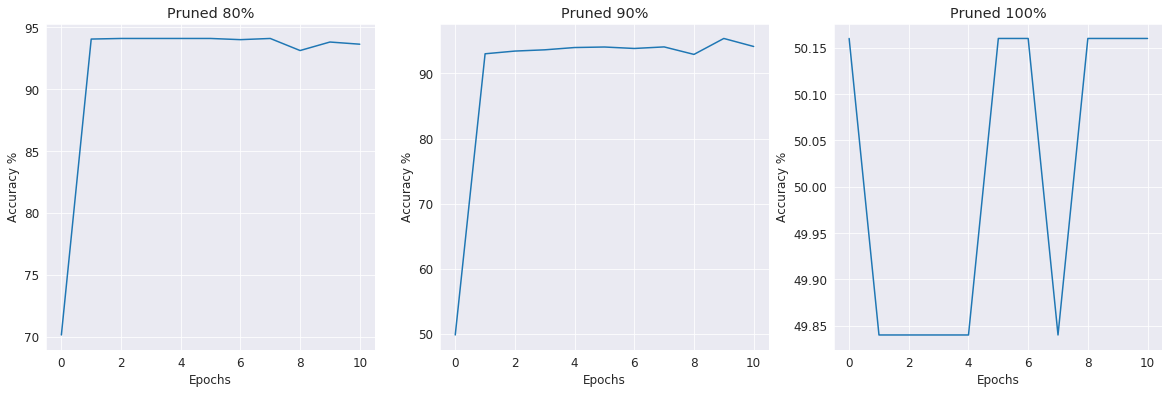

In [29]:
plt.figure(figsize=(20, 6))
plt.subplots_adjust(hspace=0.3)
for i, perc in enumerate(retrain_after):
    plt.subplot(1,3,i+1)
    plt.title('Pruned {}%'.format(retrain_after[i]))
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy %')
    plt.plot(retrain_accs[i])
plt.savefig('./accuracies/{}-i2h-retrain-accuracy.png'.format(MODEL))

In [0]:
write_line = ''

In [0]:
for i, a in enumerate(retrain_accs):
    write_line += '{}%'.format(retrain_after[i]) + ':' + ','.join(str(_a.item()) for _a in a) + '\n'

In [0]:
with open('./accuracies/{}-i2h-retrain-accuracies.txt'.format(MODEL), 'a') as f:
    f.write(write_line)